In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install --quiet SimpleITK nibabel

import os
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Paths
RAW_PATH = "/kaggle/input/brats-2021-task1"
WORK_DIR = "/kaggle/working/brats2021"
PROCESSED_DIR = "/kaggle/working/brats2021_processed"

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

print("Folders created:")
print(WORK_DIR)
print(PROCESSED_DIR)


Folders created:
/kaggle/working/brats2021
/kaggle/working/brats2021_processed


In [2]:
# Extract the full dataset TAR file (the one containing all patients)
!tar -xf /kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar -C /kaggle/working/brats2021

# Show first 10 folders to confirm extraction worked
folders = sorted(os.listdir(WORK_DIR))
print("Total extracted items:", len(folders))
print(folders[:10])


Total extracted items: 1252
['.DS_Store', 'BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_00008', 'BraTS2021_00009', 'BraTS2021_00011', 'BraTS2021_00012']


In [3]:
import os

required_mods = ["flair", "t1", "t1ce", "t2", "seg"]

def has_all_modalities(folder_path, sid):
    for mod in required_mods:
        if not os.path.exists(os.path.join(folder_path, f"{sid}_{mod}.nii.gz")):
            return False
    return True

valid_subjects = []

for d in sorted(os.listdir(WORK_DIR)):
    folder_path = os.path.join(WORK_DIR, d)
    if os.path.isdir(folder_path) and d.startswith("BraTS2021"):
        if has_all_modalities(folder_path, d):
            valid_subjects.append(d)

print("✅ Valid subjects found:", len(valid_subjects))
print(valid_subjects[:10])


✅ Valid subjects found: 1251
['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_00008', 'BraTS2021_00009', 'BraTS2021_00011', 'BraTS2021_00012', 'BraTS2021_00014']


In [4]:
def load_nifti_sitk(path):
    """
    Loads NIfTI using SimpleITK (safe for spacing, orientation, etc.)
    Returns:
        volume: np.ndarray (z,y,x)
        spacing: tuple (x_spacing, y_spacing, z_spacing)
    """
    img = sitk.ReadImage(path)
    vol = sitk.GetArrayFromImage(img)  # converts to numpy, axis order = (z, y, x)
    spacing = img.GetSpacing()         # spacing = (x, y, z) — note ordering
    return vol.astype(np.float32), spacing


In [5]:
test_id = valid_subjects[0]
path = os.path.join(WORK_DIR, test_id, f"{test_id}_flair.nii.gz")

vol, spacing = load_nifti_sitk(path)

print("Patient:", test_id)
print("Volume shape:", vol.shape)
print("Spacing:", spacing)
print("Min/Max:", np.min(vol), np.max(vol))


Patient: BraTS2021_00000
Volume shape: (155, 240, 240)
Spacing: (1.0, 1.0, 1.0)
Min/Max: 0.0 2934.0


In [6]:
import numpy as np

def get_brain_bbox(volume):
    """
    Computes bounding box around non-zero brain region.
    Input volume shape expected: (Z, Y, X)
    """
    nonzero = np.where(volume != 0)
    if len(nonzero[0]) == 0:
        # Should not happen in BraTS, but safe
        return (0, volume.shape[0], 0, volume.shape[1], 0, volume.shape[2])

    z1, z2 = nonzero[0].min(), nonzero[0].max()
    y1, y2 = nonzero[1].min(), nonzero[1].max()
    x1, x2 = nonzero[2].min(), nonzero[2].max()

    return (z1, z2, y1, y2, x1, x2)


def crop_volume(volume):
    """
    Crop volume to brain region based on non-zero mask.
    """
    z1, z2, y1, y2, x1, x2 = get_brain_bbox(volume)
    return volume[z1:z2+1, y1:y2+1, x1:x2+1]


In [7]:
# Test cropping on BraTS2021_00000 (FLAIR)
test_id = valid_subjects[0]
path = os.path.join(WORK_DIR, test_id, f"{test_id}_flair.nii.gz")

vol, _ = load_nifti_sitk(path)
cropped = crop_volume(vol)

print("Original shape:", vol.shape)
print("Cropped shape:", cropped.shape)
print("Min/Max:", np.min(cropped), np.max(cropped))


Original shape: (155, 240, 240)
Cropped shape: (146, 171, 136)
Min/Max: 0.0 2934.0


In [8]:
def resample_image_sitk(image, new_spacing=(1.0,1.0,1.0), interpolator=sitk.sitkLinear):
    """
    Correct 3D resampling function.
    Maintains direction, origin, spacing.
    """
    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    new_spacing = np.array(new_spacing)

    new_size = (original_size * (original_spacing / new_spacing)).astype(int).tolist()

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(interpolator)
    resampler.SetOutputSpacing(new_spacing.tolist())
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetDefaultPixelValue(0)

    new_img = resampler.Execute(image)
    new_vol = sitk.GetArrayFromImage(new_img)  # (z,y,x)

    return new_vol.astype(np.float32)


In [9]:
# Load original
test_id = valid_subjects[0]
path = os.path.join(WORK_DIR, test_id, f"{test_id}_flair.nii.gz")
sitk_img = sitk.ReadImage(path)

# Convert to numpy, then crop
np_vol = sitk.GetArrayFromImage(sitk_img)
cropped = crop_volume(np_vol)

print("Cropped shape:", cropped.shape)

# Convert cropped back to SITK image
cropped_sitk = sitk.GetImageFromArray(cropped)
cropped_sitk.SetSpacing(sitk_img.GetSpacing())  # preserve original spacing

# Correct resampling
resampled = resample_image_sitk(cropped_sitk, new_spacing=(1.0,1.0,1.0))

print("Resampled shape:", resampled.shape)
print("Min/Max:", np.min(resampled), np.max(resampled))


Cropped shape: (146, 171, 136)
Resampled shape: (146, 171, 136)
Min/Max: 0.0 2934.0


In [10]:
def normalize_brain(vol):
    """
    Normalize intensities only where vol != 0.
    Keeps background = 0.
    """
    mask = vol > 0
    if np.sum(mask) == 0:
        return vol  # shouldn't happen in BraTS

    mean = vol[mask].mean()
    std = vol[mask].std() + 1e-8

    out = (vol - mean) / std
    out[~mask] = 0
    return out.astype(np.float32)


Before normalization: min/max = 0 2934
After normalization: min/max = -2.7567189 5.442381


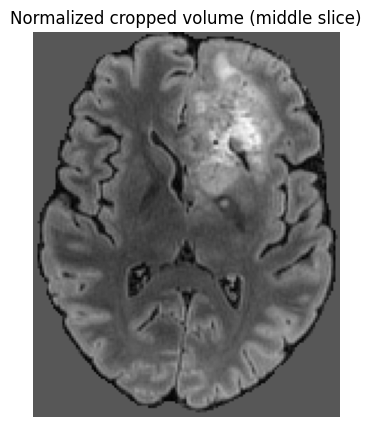

In [11]:
norm = normalize_brain(cropped)

print("Before normalization: min/max =", np.min(cropped), np.max(cropped))
print("After normalization: min/max =", np.min(norm), np.max(norm))

# Show a slice
plt.figure(figsize=(5,5))
plt.imshow(norm[cropped.shape[0]//2], cmap="gray")
plt.title("Normalized cropped volume (middle slice)")
plt.axis("off")
plt.show()


In [12]:
def resize_volume(vol, target_shape=(128,128,128)):
    """
    Resize MRI volume using trilinear interpolation.
    Input shape: (Z,Y,X)
    Output shape: (128,128,128)
    """
    vol_t = torch.tensor(vol).unsqueeze(0).unsqueeze(0).float()  # (1,1,Z,Y,X)
    resized = F.interpolate(
        vol_t,
        size=target_shape,
        mode="trilinear",
        align_corners=False
    )
    return resized.squeeze().numpy().astype(np.float32)


In [13]:
def resize_mask(mask, target_shape=(128,128,128)):
    """
    Resize segmentation mask using nearest neighbor.
    Ensures labels stay integer and unbroken.
    """
    m = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float()
    m2 = F.interpolate(
        m,
        size=target_shape,
        mode="nearest"
    )
    return m2.squeeze().numpy().astype(np.uint8)


Cropped shape: (146, 171, 136)
Resized shape: (128, 128, 128)
Min/Max: -2.6682234 5.098456


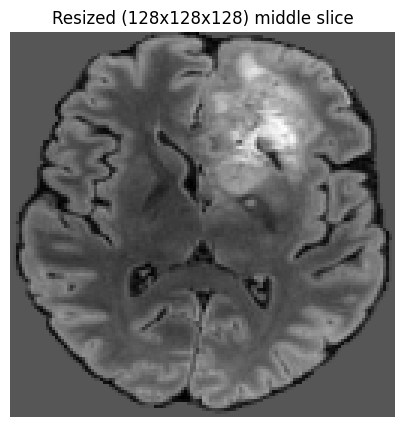

In [14]:
resized_test = resize_volume(norm)

print("Cropped shape:", cropped.shape)
print("Resized shape:", resized_test.shape)
print("Min/Max:", np.min(resized_test), np.max(resized_test))

plt.figure(figsize=(5,5))
plt.imshow(resized_test[64], cmap="gray")
plt.title("Resized (128x128x128) middle slice")
plt.axis("off")
plt.show()


In [15]:
def preprocess_subject(subject_id, base_path=WORK_DIR, target_shape=(128,128,128)):
    """
    Preprocesses a single BraTS subject:
    - Loads modalities
    - Crops to brain mask
    - Resamples to 1mm³
    - Normalizes each modality
    - Resizes to 128³
    - Loads and processes segmentation
    """
    sid = subject_id
    subject_path = os.path.join(base_path, sid)

    modalities = ["flair", "t1", "t1ce", "t2"]
    vols = []
    cropped_masks = []

    # -------- 1. Load all modalities using SITK --------
    sitk_mods = {}
    for mod in modalities:
        path = os.path.join(subject_path, f"{sid}_{mod}.nii.gz")
        img = sitk.ReadImage(path)
        sitk_mods[mod] = img

    # -------- 2. Compute crop mask FROM FLAIR (best contrast) --------
    flair_np = sitk.GetArrayFromImage(sitk_mods["flair"])
    cropped_mask = crop_volume(flair_np)

    z1,z2,y1,y2,x1,x2 = get_brain_bbox(flair_np)

    # -------- 3. Process each modality --------
    for mod in modalities:
        img_np = sitk.GetArrayFromImage(sitk_mods[mod])

        # Crop
        img_np = img_np[z1:z2+1, y1:y2+1, x1:x2+1]

        # Convert cropped NP → SITK for correct spacing
        cropped_sitk = sitk.GetImageFromArray(img_np)
        cropped_sitk.SetSpacing(sitk_mods[mod].GetSpacing())

        # Resample to 1mm³
        resampled = resample_image_sitk(cropped_sitk, new_spacing=(1,1,1))

        # Normalize brain only
        resampled = normalize_brain(resampled)

        # Resize to 128³
        resized = resize_volume(resampled, target_shape)

        vols.append(resized)

    # -------- 4. Process segmentation --------
    seg_path = os.path.join(subject_path, f"{sid}_seg.nii.gz")
    seg_sitk = sitk.ReadImage(seg_path)
    seg_np = sitk.GetArrayFromImage(seg_sitk)

    # Crop with same bounding box
    seg_np = seg_np[z1:z2+1, y1:y2+1, x1:x2+1]

    # Remap labels: 4 -> 3
    seg_np[seg_np == 4] = 3

    # Resize mask
    seg_resized = resize_mask(seg_np, target_shape)

    X = np.stack(vols)  # shape (4,128,128,128)
    Y = seg_resized     # shape (128,128,128)

    return X.astype(np.float32), Y.astype(np.uint8)


X shape: (4, 128, 128, 128)
Y shape: (128, 128, 128)
Y labels: [0 1 2 3]


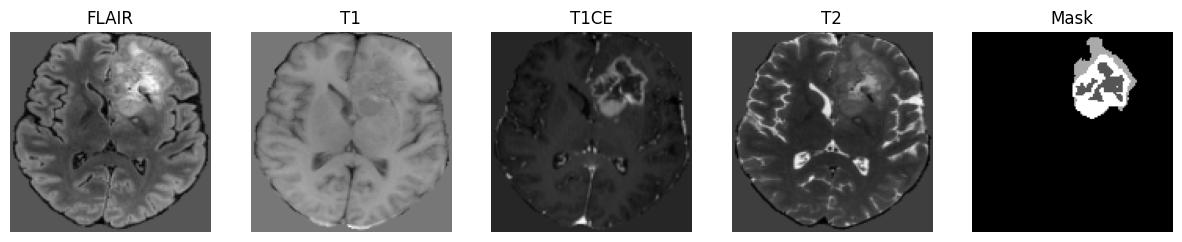

In [16]:
test_id = valid_subjects[0]
X, Y = preprocess_subject(test_id)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Y labels:", np.unique(Y))

# Show 4 modalities + mask (middle slice)
mid = X.shape[1] // 2

plt.figure(figsize=(15,4))
titles = ["FLAIR", "T1", "T1CE", "T2"]

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i,mid], cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.subplot(1,5,5)
plt.imshow(Y[mid], cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()


In [17]:
SAMPLE_IDS = valid_subjects[:100]   # process first 3 patients

for sid in SAMPLE_IDS:
    print(f"\n🔄 Processing {sid}")
    X, Y = preprocess_subject(sid)

    np.save(os.path.join(PROCESSED_DIR, f"{sid}_X.npy"), X)
    np.save(os.path.join(PROCESSED_DIR, f"{sid}_Y.npy"), Y)

    print(f"✅ Saved {sid}: X {X.shape}, Y {Y.shape}, labels {np.unique(Y)}")



🔄 Processing BraTS2021_00000
✅ Saved BraTS2021_00000: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00002
✅ Saved BraTS2021_00002: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00003
✅ Saved BraTS2021_00003: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00005
✅ Saved BraTS2021_00005: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00006
✅ Saved BraTS2021_00006: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00008
✅ Saved BraTS2021_00008: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00009
✅ Saved BraTS2021_00009: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00011
✅ Saved BraTS2021_00011: X (4, 128, 128, 128), Y (128, 128, 128), labels [0 1 2 3]

🔄 Processing BraTS2021_00012
✅ Saved BraTS2021_00012: X (4, 128, 128, 128), Y (128, 128, 128), 

precess all the dataset later 


In [17]:
from tqdm import tqdm

print("Starting full preprocessing...")
errors = []

for sid in tqdm(valid_subjects, total=len(valid_subjects)):
    try:
        X, Y = preprocess_subject(sid)
        np.save(os.path.join(PROCESSED_DIR, f"{sid}_X.npy"), X)
        np.save(os.path.join(PROCESSED_DIR, f"{sid}_Y.npy"), Y)
    except Exception as e:
        print(f"❌ Error in {sid}: {e}")
        errors.append((sid, str(e)))

print("\nDone!")
print("Patients with errors:", errors)


Starting full preprocessing...


 17%|█▋        | 212/1251 [02:09<13:04,  1.33it/s]

❌ Error in BraTS2021_00298: Not enough free space to write 33554432 bytes


 17%|█▋        | 213/1251 [02:09<11:58,  1.44it/s]

❌ Error in BraTS2021_00299: [Errno 28] No space left on device


 17%|█▋        | 214/1251 [02:10<11:17,  1.53it/s]

❌ Error in BraTS2021_00300: [Errno 28] No space left on device


 17%|█▋        | 215/1251 [02:10<10:53,  1.58it/s]

❌ Error in BraTS2021_00301: [Errno 28] No space left on device


 17%|█▋        | 216/1251 [02:11<10:38,  1.62it/s]

❌ Error in BraTS2021_00303: [Errno 28] No space left on device


 17%|█▋        | 217/1251 [02:12<10:29,  1.64it/s]

❌ Error in BraTS2021_00304: [Errno 28] No space left on device


 17%|█▋        | 218/1251 [02:12<10:24,  1.65it/s]

❌ Error in BraTS2021_00305: [Errno 28] No space left on device


 18%|█▊        | 219/1251 [02:13<10:07,  1.70it/s]

❌ Error in BraTS2021_00306: [Errno 28] No space left on device


 18%|█▊        | 220/1251 [02:13<10:27,  1.64it/s]

❌ Error in BraTS2021_00309: [Errno 28] No space left on device


 18%|█▊        | 221/1251 [02:14<10:02,  1.71it/s]

❌ Error in BraTS2021_00310: [Errno 28] No space left on device


 18%|█▊        | 221/1251 [02:14<10:28,  1.64it/s]


KeyboardInterrupt: 

**PHASE 1: TRAINING PIPELINE (DEBUG MODE)**

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class BraTSDebugDataset(Dataset):
    def __init__(self, processed_dir, subject_ids):
        self.processed_dir = processed_dir
        self.subject_ids = subject_ids

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        sid = self.subject_ids[idx]
        
        X = np.load(os.path.join(self.processed_dir, f"{sid}_X.npy"))
        Y = np.load(os.path.join(self.processed_dir, f"{sid}_Y.npy"))
        
        # Convert to tensors
        X = torch.tensor(X).float()
        Y = torch.tensor(Y).long()

        return X, Y

# Use only the 5 patients we preprocessed
train_ids = [
    "BraTS2021_00000",
    "BraTS2021_00002",
    "BraTS2021_00003",
    "BraTS2021_00005",
    "BraTS2021_00006",
]

train_dataset = BraTSDebugDataset(PROCESSED_DIR, train_ids)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Check shapes from one batch:
for X, Y in train_loader:
    print("Batch X:", X.shape)  # (1,4,128,128,128)
    print("Batch Y:", Y.shape)  # (1,128,128,128)
    break


Batch X: torch.Size([1, 4, 128, 128, 128])
Batch Y: torch.Size([1, 128, 128, 128])


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Basic 3D convolutional block
# -----------------------------
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# -----------------------------
# 3D U-Net
# -----------------------------
class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()

        self.enc1 = ConvBlock3D(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ConvBlock3D(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = ConvBlock3D(64, 128)
        self.pool3 = nn.MaxPool3d(2)

        self.bottleneck = ConvBlock3D(128, 256)

        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = ConvBlock3D(256, 128)

        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = ConvBlock3D(128, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = ConvBlock3D(64, 32)

        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        return self.out_conv(d1)

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D().to(device)

# Test with one batch
X_test, Y_test = next(iter(train_loader))
X_test = X_test.to(device)

with torch.no_grad():
    out = model(X_test)

print("Model output shape:", out.shape)  # (1, 4, 128,128,128)


Model output shape: torch.Size([1, 4, 128, 128, 128])


In [23]:
import torch.nn as nn

# -----------------------------
# Dice Loss for multi-class
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        logits: (B, C, D, H, W)
        targets: (B, D, H, W)
        """
        num_classes = logits.shape[1]

        # Softmax
        probs = torch.softmax(logits, dim=1)

        # One-hot encode targets
        targets_onehot = F.one_hot(targets, num_classes=num_classes)
        targets_onehot = targets_onehot.permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)

        intersection = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs + targets_onehot, dims)

        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        loss = 1 - dice.mean()
        return loss

# -----------------------------
# Weighted CrossEntropy
# -----------------------------
class WeightedCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)

    def forward(self, logits, targets):
        return self.ce(logits, targets)

# -----------------------------
# Combine both losses
# -----------------------------
weights = torch.tensor([0.2, 1.0, 1.5, 2.0]).to(device)  
# bg, tumor1, tumor2, tumor3

dice_loss_fn = DiceLoss()
ce_loss_fn = WeightedCELoss(weights)

def total_loss_fn(logits, targets):
    return 0.5 * dice_loss_fn(logits, targets) + 0.5 * ce_loss_fn(logits, targets)


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 3  # debug mode

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()

        logits = model(X)
        loss = total_loss_fn(logits, Y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/3 | Loss: 1.0238
Epoch 2/3 | Loss: 0.9243
Epoch 3/3 | Loss: 0.8696


Dice per class [0,1,2,3]: [0.9213424655887934, 0.10030678232159888, 0.04751871473340036, 0.49236053242766364]


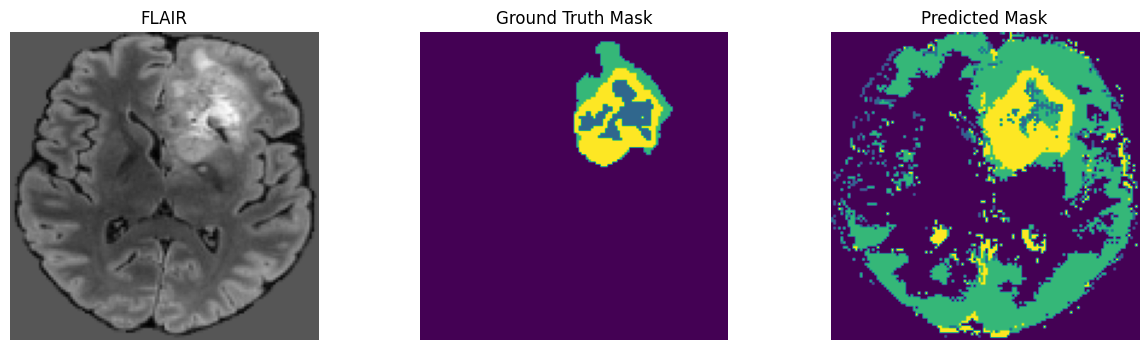

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def dice_coef(pred, target, num_classes=4, smooth=1e-5):
    dices = []
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    for c in range(num_classes):
        p = (pred == c).astype(np.uint8)
        t = (target == c).astype(np.uint8)

        inter = (p * t).sum()
        union = p.sum() + t.sum()
        d = (2 * inter + smooth) / (union + smooth)
        dices.append(d)
    return dices


# ---------------------------
# Run model on 1 patient
# ---------------------------
model.eval()

sid = train_ids[0]   # patient 00000
X = np.load(os.path.join(PROCESSED_DIR, f"{sid}_X.npy"))
Y = np.load(os.path.join(PROCESSED_DIR, f"{sid}_Y.npy"))

X_t = torch.tensor(X).unsqueeze(0).to(device)  # (1,4,128,128,128)
Y_t = torch.tensor(Y).to(device)               # (128,128,128)

with torch.no_grad():
    logits = model(X_t)
    pred = torch.argmax(logits, dim=1).squeeze(0)  # (128,128,128)

# Compute Dice
dice = dice_coef(pred, Y_t)
print("Dice per class [0,1,2,3]:", dice)

# ---------------------------
# Show slices
# ---------------------------
mid = X.shape[1] // 2

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(X[0,mid], cmap="gray")
plt.title("FLAIR")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Y[mid])
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred.cpu().numpy()[mid])
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


🚀 PHASE 2 — Upgrade Training Pipeline

AMP (Automatic Mixed Precision)

Gradient Accumulation

Batch size simulation

Learning rate schedule

More channels in U-Net

Full dataset

Strong augmentation

In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

PROCESSED_DIR = "/kaggle/working/brats2021_processed"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [27]:
train_ids = [
    "BraTS2021_00000",
    "BraTS2021_00002",
    "BraTS2021_00003",
    "BraTS2021_00005",
    "BraTS2021_00006",
]

train_split = train_ids[:4]
val_split   = train_ids[4:]

print("Training on:", train_split)
print("Validating on:", val_split)


Training on: ['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005']
Validating on: ['BraTS2021_00006']


In [28]:
class BraTSDataset(Dataset):
    def __init__(self, processed_dir, subject_ids):
        self.processed_dir = processed_dir
        self.subject_ids = subject_ids

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        sid = self.subject_ids[idx]
        
        X = np.load(os.path.join(self.processed_dir, f"{sid}_X.npy"))
        Y = np.load(os.path.join(self.processed_dir, f"{sid}_Y.npy"))
        
        X = torch.tensor(X).float()
        Y = torch.tensor(Y).long()

        return X, Y


In [29]:
train_loader = DataLoader(
    BraTSDataset(PROCESSED_DIR, train_split),
    batch_size=1, shuffle=True
)

val_loader = DataLoader(
    BraTSDataset(PROCESSED_DIR, val_split),
    batch_size=1, shuffle=False
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 4
Val batches: 1


In [30]:
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = ConvBlock3D(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ConvBlock3D(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = ConvBlock3D(64, 128)
        self.pool3 = nn.MaxPool3d(2)

        self.bottleneck = ConvBlock3D(128, 256)

        self.up3 = nn.ConvTranspose3d(256, 128, 2, 2)
        self.dec3 = ConvBlock3D(256, 128)

        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = ConvBlock3D(128, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = ConvBlock3D(64, 32)

        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        b = self.bottleneck(self.pool3(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out_conv(d1)

model = UNet3D().to(device)


In [31]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = torch.softmax(logits, dim=1)

        targets_onehot = F.one_hot(targets, num_classes=num_classes)
        targets_onehot = targets_onehot.permute(0,4,1,2,3).float()

        dims = (0,2,3,4)
        inter = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs + targets_onehot, dims)

        dice = (2*inter + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


class WeightedCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)

    def forward(self, logits, targets):
        return self.ce(logits, targets)


weights = torch.tensor([0.2, 1.0, 1.5, 2.0]).to(device)
dice_loss_fn = DiceLoss()
ce_loss_fn = WeightedCELoss(weights)

def total_loss_fn(logits, targets):
    return 0.5 * dice_loss_fn(logits, targets) + 0.5 * ce_loss_fn(logits, targets)


In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

epochs = 5
accum_steps = 4  # simulate batch size 4

for epoch in range(epochs):
    model.train()
    train_loss = 0

    optimizer.zero_grad()

    for i, (X, Y) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)

        with torch.cuda.amp.autocast():
            logits = model(X)
            loss = total_loss_fn(logits, Y) / accum_steps

        scaler.scale(loss).backward()

        if (i+1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * accum_steps

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xv, Yv in val_loader:
            Xv = Xv.to(device)
            Yv = Yv.to(device)
            logits = model(Xv)
            val_loss += total_loss_fn(logits, Yv).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")


/tmp/ipykernel_48/1538923674.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_48/1538923674.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5 | Train Loss: 1.1488 | Val Loss: 1.1128
Epoch 2/5 | Train Loss: 1.0987 | Val Loss: 1.0688
Epoch 3/5 | Train Loss: 1.0683 | Val Loss: 1.0403
Epoch 4/5 | Train Loss: 1.0476 | Val Loss: 1.0183
Epoch 5/5 | Train Loss: 1.0305 | Val Loss: 0.9998


Dice per class:
Class 0: 0.8353
Class 1: 0.1866
Class 2: 0.2360
Class 3: 0.0920


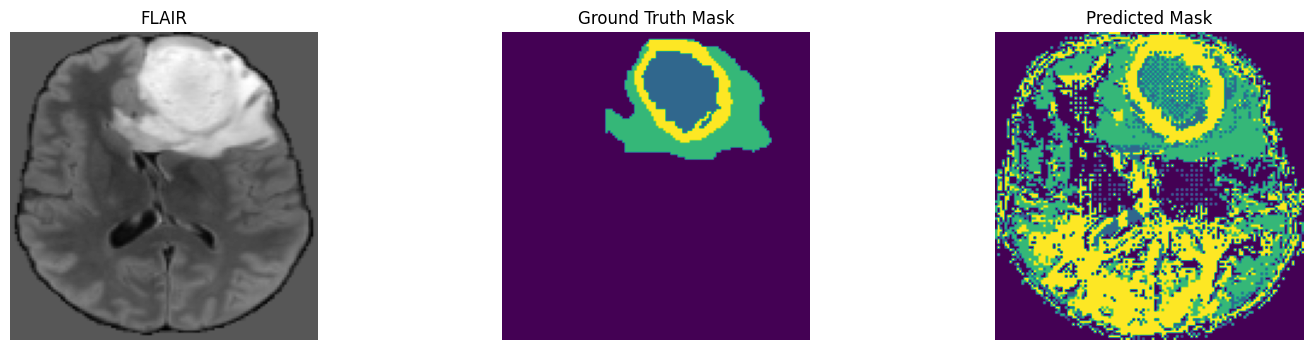

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def dice_coef(pred, target, cls, smooth=1e-5):
    pred_c = (pred == cls).float()
    target_c = (target == cls).float()

    inter = (pred_c * target_c).sum()
    union = pred_c.sum() + target_c.sum()

    return (2 * inter + smooth) / (union + smooth)

# -----------------------------
# Run validation patient
# -----------------------------
model.eval()

sid = val_split[0]  # one patient for validation
X = np.load(os.path.join(PROCESSED_DIR, f"{sid}_X.npy"))
Y = np.load(os.path.join(PROCESSED_DIR, f"{sid}_Y.npy"))

X_t = torch.tensor(X).unsqueeze(0).to(device)
Y_t = torch.tensor(Y).to(device)

with torch.no_grad():
    logits = model(X_t)
    pred = torch.argmax(logits, dim=1).squeeze(0)

# -----------------------------
# Dice per class
# -----------------------------
print("Dice per class:")
for c in range(4):
    d = dice_coef(pred.cpu(), Y_t.cpu(), c)
    print(f"Class {c}: {d:.4f}")

# -----------------------------
# Visualization
# -----------------------------
mid = X.shape[1] // 2

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(X[0, mid], cmap="gray")
plt.title("FLAIR")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Y[mid])
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred.cpu().numpy()[mid])
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


**PHASE 3**

In [18]:
import os

xs = [f for f in os.listdir(PROCESSED_DIR) if f.endswith("_X.npy")]
ys = [f for f in os.listdir(PROCESSED_DIR) if f.endswith("_Y.npy")]

print("X files:", len(xs))
print("Y files:", len(ys))


X files: 100
Y files: 100


In [19]:
!df -h /kaggle/working


Filesystem      Size  Used Avail Use% Mounted on
/dev/loop1       20G   16G  3.8G  82% /kaggle/working


In [20]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# list subject IDs
subject_ids = sorted([f.replace("_X.npy", "") for f in os.listdir(PROCESSED_DIR) if f.endswith("_X.npy")])

print("Total subjects in this chunk:", len(subject_ids))

# 80/20 split
split = int(0.8 * len(subject_ids))
train_ids = subject_ids[:split]
val_ids   = subject_ids[split:]

print("Train patients:", len(train_ids))
print("Val patients:", len(val_ids))


class BraTSDataset(Dataset):
    def __init__(self, ids, dir):
        self.ids = ids
        self.dir = dir

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sid = self.ids[idx]
        X = np.load(f"{self.dir}/{sid}_X.npy")
        Y = np.load(f"{self.dir}/{sid}_Y.npy")
        return torch.tensor(X), torch.tensor(Y)
        

train_dataset = BraTSDataset(train_ids, PROCESSED_DIR)
val_dataset   = BraTSDataset(val_ids, PROCESSED_DIR)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)


Total subjects in this chunk: 100
Train patients: 80
Val patients: 20


In [25]:
import torch
import torch.nn as nn

# ==========================
# 3D Conv Block
# ==========================
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


# ==========================
# U-Net 3D
# ==========================
class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, features=[32, 64, 128, 256]):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock3D(in_channels, features[0])
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ConvBlock3D(features[0], features[1])
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = ConvBlock3D(features[1], features[2])
        self.pool3 = nn.MaxPool3d(2)

        self.enc4 = ConvBlock3D(features[2], features[3])

        # Decoder
        self.up3 = nn.ConvTranspose3d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = ConvBlock3D(features[2] * 2, features[2])

        self.up2 = nn.ConvTranspose3d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = ConvBlock3D(features[1] * 2, features[1])

        self.up1 = nn.ConvTranspose3d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = ConvBlock3D(features[0] * 2, features[0])

        # Output layer
        self.out_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        d3 = self.up3(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)


In [27]:
model = UNet3D().to("cuda")
print("Model loaded on GPU!")


Model loaded on GPU!


In [26]:
def dice_loss(pred, target, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    dice = 0
    for c in range(4):
        pred_c = pred[:, c]
        target_c = (target == c).float()
        inter = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        dice += 1 - (2 * inter + epsilon) / (union + epsilon)
    return dice / 4


ce_loss = nn.CrossEntropyLoss()

def combined_loss(pred, target):
    return 0.5 * ce_loss(pred, target) + 0.5 * dice_loss(pred, target)


In [23]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Collect subject IDs from processed dir
subject_ids = sorted([
    f.replace("_X.npy", "") 
    for f in os.listdir(PROCESSED_DIR) 
    if f.endswith("_X.npy")
])

print("Total subjects in this chunk:", len(subject_ids))

# 80/20 split
split = int(0.8 * len(subject_ids))
train_ids = subject_ids[:split]
val_ids   = subject_ids[split:]

print("Train patients:", len(train_ids))
print("Val patients:", len(val_ids))


class BraTSDataset(Dataset):
    def __init__(self, ids, dir):
        self.ids = ids
        self.dir = dir

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sid = self.ids[idx]

        # Load arrays
        X = np.load(f"{self.dir}/{sid}_X.npy")  # shape: (4, 128,128,128)
        Y = np.load(f"{self.dir}/{sid}_Y.npy")  # shape: (128,128,128)

        return torch.tensor(X), torch.tensor(Y)


# Dataloaders
train_dataset = BraTSDataset(train_ids, PROCESSED_DIR)
val_dataset   = BraTSDataset(val_ids, PROCESSED_DIR)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)


Total subjects in this chunk: 100
Train patients: 80
Val patients: 20


In [28]:
device = "cuda"

# Recommended optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# AMP scaler
scaler = torch.amp.GradScaler("cuda")

# How many steps to accumulate
ACCUM_STEPS = 4   # effective batch size = 4

EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    optimizer.zero_grad()

    for step, (X, Y) in enumerate(train_loader):
        X = X.float().to(device)
        Y = Y.long().to(device)

        with torch.amp.autocast("cuda"):
            pred = model(X)
            loss = combined_loss(pred, Y)
            loss = loss / ACCUM_STEPS  # normalize accumulated loss

        scaler.scale(loss).backward()

        # Gradient accumulation update
        if (step + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * ACCUM_STEPS  # un-scale for logging

    # ----------------------
    # Validation
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad(), torch.amp.autocast("cuda"):
        for X, Y in val_loader:
            X = X.float().to(device)
            Y = Y.long().to(device)

            pred = model(X)
            loss = combined_loss(pred, Y)
            val_loss += loss.item()

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/10 | Train Loss: 0.9947 | Val Loss: 0.9102
Epoch 2/10 | Train Loss: 0.8556 | Val Loss: 0.8082
Epoch 3/10 | Train Loss: 0.8045 | Val Loss: 0.7876
Epoch 4/10 | Train Loss: 0.7764 | Val Loss: 0.7791
Epoch 5/10 | Train Loss: 0.7555 | Val Loss: 0.7543
Epoch 6/10 | Train Loss: 0.7362 | Val Loss: 0.7470
Epoch 7/10 | Train Loss: 0.7193 | Val Loss: 0.7147
Epoch 8/10 | Train Loss: 0.7041 | Val Loss: 0.7071
Epoch 9/10 | Train Loss: 0.6876 | Val Loss: 0.6771
Epoch 10/10 | Train Loss: 0.6731 | Val Loss: 0.6647


In [29]:
torch.save(model.state_dict(), "model_chunk0.pth")


In [31]:
model.eval()


UNet3D(
  (enc1): ConvBlock3D(
    (block): Sequential(
      (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock3D(
    (block): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [33]:
import os
from sklearn.model_selection import train_test_split

PROCESSED_DIR = "/kaggle/working/brats2021_processed"

# List all processed X.npy files
processed_X = sorted([f for f in os.listdir(PROCESSED_DIR) if f.endswith("_X.npy")])

# Extract patient IDs
all_subjects = [f.replace("_X.npy", "") for f in processed_X]

print("Total processed subjects:", len(all_subjects))

# Train/Val split
train_subjects, val_subjects = train_test_split(
    all_subjects, test_size=0.2, random_state=42
)

print("Train:", len(train_subjects))
print("Val:", len(val_subjects))

print("First 5 train subjects:", train_subjects[:5])
print("First 5 val subjects:", val_subjects[:5])


Total processed subjects: 100
Train: 80
Val: 20
First 5 train subjects: ['BraTS2021_00085', 'BraTS2021_00124', 'BraTS2021_00036', 'BraTS2021_00062', 'BraTS2021_00103']
First 5 val subjects: ['BraTS2021_00118', 'BraTS2021_00081', 'BraTS2021_00104', 'BraTS2021_00066', 'BraTS2021_00064']


In [34]:
val_subjects[:5]


['BraTS2021_00118',
 'BraTS2021_00081',
 'BraTS2021_00104',
 'BraTS2021_00066',
 'BraTS2021_00064']

In [35]:
import numpy as np

patient_id = val_subjects[0]  # try the first one
X = np.load(f"{PROCESSED_DIR}/{patient_id}_X.npy")
Y = np.load(f"{PROCESSED_DIR}/{patient_id}_Y.npy")

print(X.shape, Y.shape, np.unique(Y))


(4, 128, 128, 128) (128, 128, 128) [0 1 2 3]


In [36]:
import torch

with torch.no_grad(), torch.amp.autocast("cuda"):
    X_tensor = torch.tensor(X).unsqueeze(0).to(device)  # [1,4,128,128,128]
    pred = model(X_tensor)  # logits
    pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()


In [37]:
def dice_score(pred, true, cls):
    pred_bin = (pred == cls)
    true_bin = (true == cls)

    intersection = (pred_bin & true_bin).sum()
    denom = pred_bin.sum() + true_bin.sum()

    if denom == 0:
        return 1.0  # perfect if class not present
    return 2 * intersection / denom

classes = [0,1,2,3]
for c in classes:
    print(f"Dice Class {c}: {dice_score(pred_mask, Y, c):.4f}")


Dice Class 0: 0.9931
Dice Class 1: 0.5746
Dice Class 2: 0.7946
Dice Class 3: 0.8504


In [38]:
def dice_region(pred, true, labels):
    pred_bin = np.isin(pred, labels)
    true_bin = np.isin(true, labels)

    inter = (pred_bin & true_bin).sum()
    denom = pred_bin.sum() + true_bin.sum()

    if denom == 0:
        return 1.0
    return 2 * inter / denom

print("WT Dice:", dice_region(pred_mask, Y, [1,2,3]))
print("TC Dice:", dice_region(pred_mask, Y, [2,3]))
print("ET Dice:", dice_region(pred_mask, Y, [3]))


WT Dice: 0.868230794796087
TC Dice: 0.8605212480470068
ET Dice: 0.8503707706625837


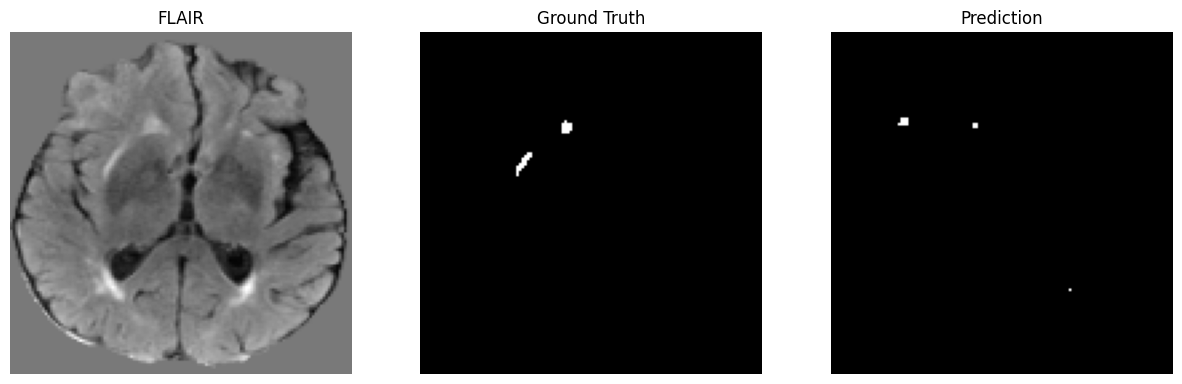

In [39]:
import matplotlib.pyplot as plt

mid = 64  # middle slice

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(X[0,mid], cmap="gray")
plt.title("FLAIR")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Y[mid], cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_mask[mid], cmap="gray")
plt.title("Prediction")
plt.axis("off")

plt.show()


In [40]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patient_slices(X, Y, pred_mask, num_slices=12):
    # select evenly spaced slices
    slices = np.linspace(10, 118, num_slices).astype(int)

    plt.figure(figsize=(15, num_slices*2))

    for i, s in enumerate(slices):
        plt.subplot(num_slices, 3, 3*i + 1)
        plt.imshow(X[0, s], cmap="gray")
        plt.title(f"FLAIR (slice {s})")
        plt.axis("off")

        plt.subplot(num_slices, 3, 3*i + 2)
        plt.imshow(Y[s], cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_slices, 3, 3*i + 3)
        plt.imshow(pred_mask[s], cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


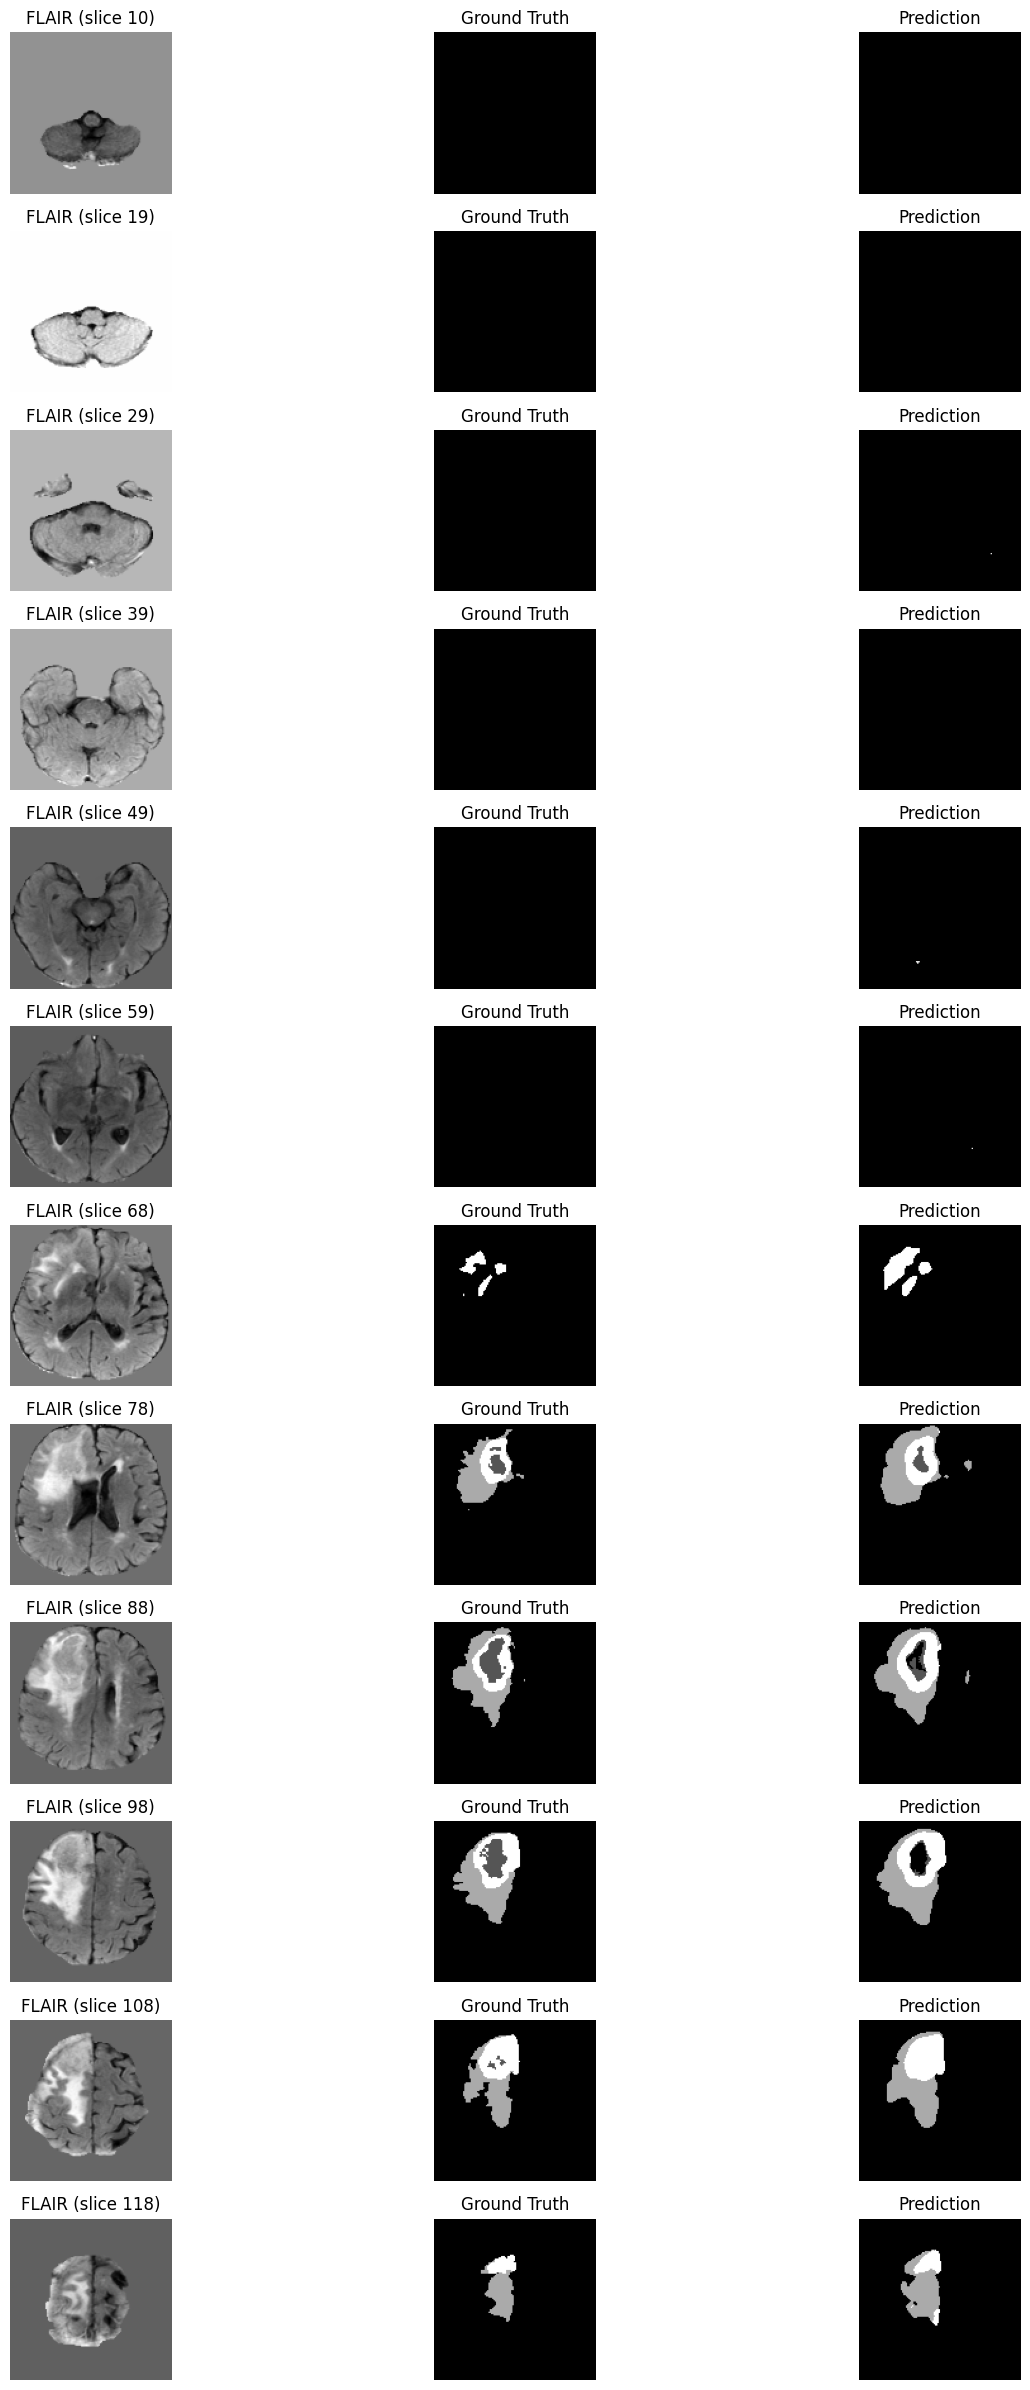

In [41]:
visualize_patient_slices(X, Y, pred_mask, num_slices=12)


In [44]:
def visualize_tumor_only(X, Y, pred_mask):
    tumor_slices = np.where(Y.sum(axis=(1,2)) > 0)[0]

    if len(tumor_slices) == 0:
        print("⚠️ No tumor in ground truth.")
        return

    plt.figure(figsize=(15, len(tumor_slices)*2))

    for i, s in enumerate(tumor_slices):
        plt.subplot(len(tumor_slices), 3, 3*i + 1)
        plt.imshow(X[0, s], cmap="gray")
        plt.title(f"FLAIR slice {s}")
        plt.axis("off")

        plt.subplot(len(tumor_slices), 3, 3*i + 2)
        plt.imshow(Y[s], cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(len(tumor_slices), 3, 3*i + 3)
        plt.imshow(pred_mask[s], cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


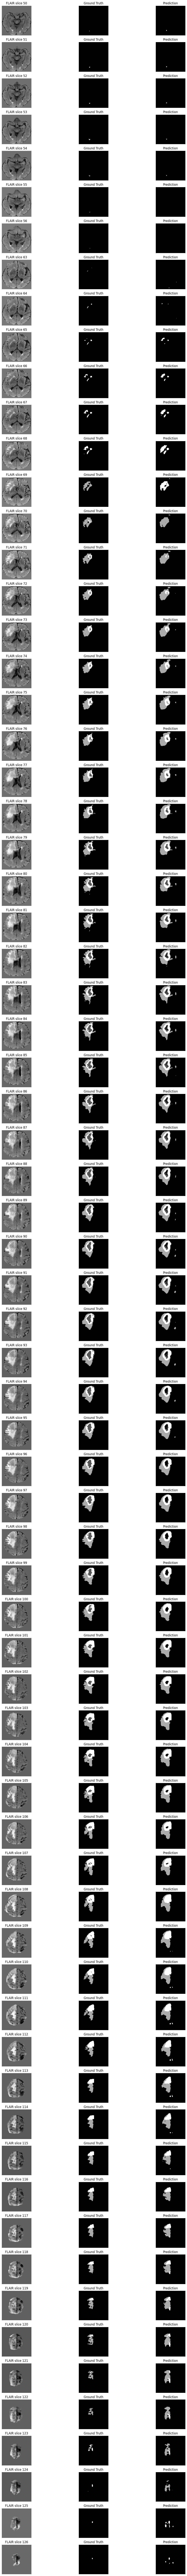

In [47]:
def visualize_tumor_only(X, Y, pred_mask):
    tumor_slices = np.where(Y.sum(axis=(1,2)) > 0)[0]
    plt.figure(figsize=(15, len(tumor_slices) * 2))

    for i, s in enumerate(tumor_slices[:10]):  # limit for clean display
        plt.subplot(10, 3, i*3 + 1)
        plt.imshow(X[0,s], cmap="gray")
        plt.title("FLAIR")
        plt.axis("off")
        
        plt.subplot(10, 3, i*3 + 2)
        plt.imshow(Y[s], cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        plt.subplot(10, 3, i*3 + 3)
        plt.imshow(pred_mask[s], cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("samples/comparison_slices.png", dpi=300)
    plt.show()


In [49]:
import os
os.makedirs("samples", exist_ok=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


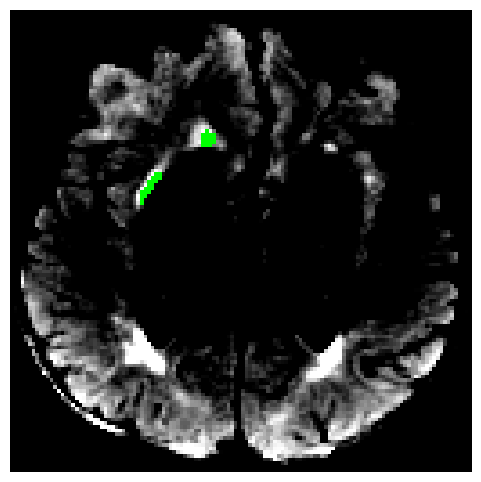

In [50]:
def overlay_mask(img, mask):
    overlay = np.stack([img, img, img], axis=-1)
    overlay[mask==1] = [255, 0, 0]   # edema red
    overlay[mask==2] = [0, 255, 0]   # necrotic core green
    overlay[mask==3] = [0, 0, 255]   # enhancing tumor blue
    return overlay

slice_id = 64
ov = overlay_mask(X[0, slice_id], Y[slice_id])

plt.figure(figsize=(6,6))
plt.imshow(ov)
plt.axis("off")
plt.savefig("samples/overlay.png", dpi=300)
plt.show()


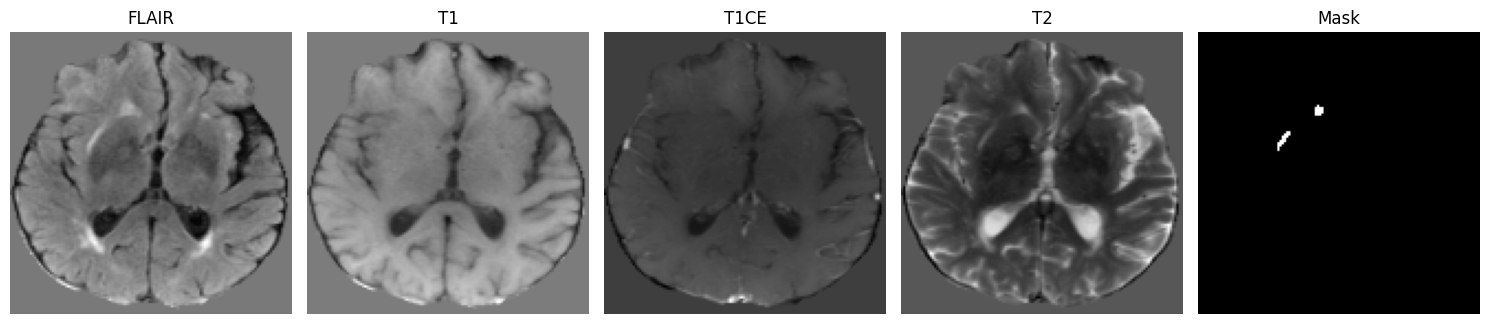

In [51]:
plt.figure(figsize=(15,4))
titles = ["FLAIR", "T1", "T1CE", "T2", "Mask"]
modalities = [0,1,2,3]

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(X[modalities[i],64], cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.subplot(1,5,5)
plt.imshow(Y[64], cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.tight_layout()
plt.savefig("samples/modalities.png", dpi=300)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


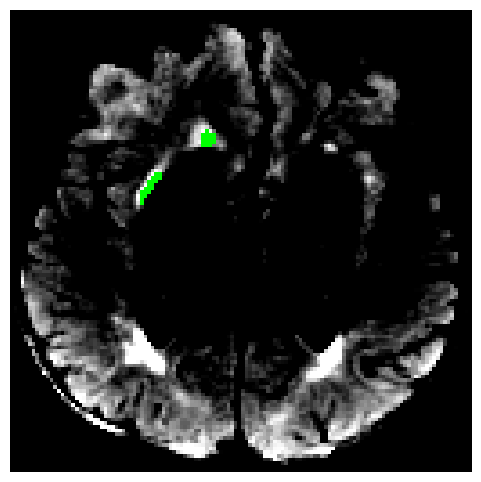

In [52]:
ov_gt = overlay_mask(X[0, slice_id], Y[slice_id])

plt.figure(figsize=(6,6))
plt.imshow(ov_gt)
plt.axis("off")
plt.savefig("samples/overlay_groundtruth.png", dpi=300)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


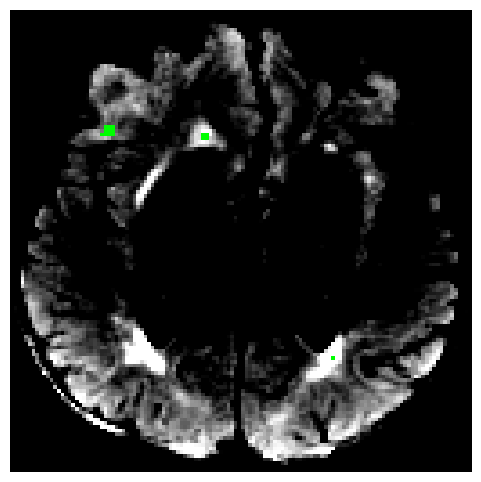

In [53]:
ov_pred = overlay_mask(X[0, slice_id], pred_mask[slice_id])

plt.figure(figsize=(6,6))
plt.imshow(ov_pred)
plt.axis("off")
plt.savefig("samples/overlay_prediction.png", dpi=300)
plt.show()


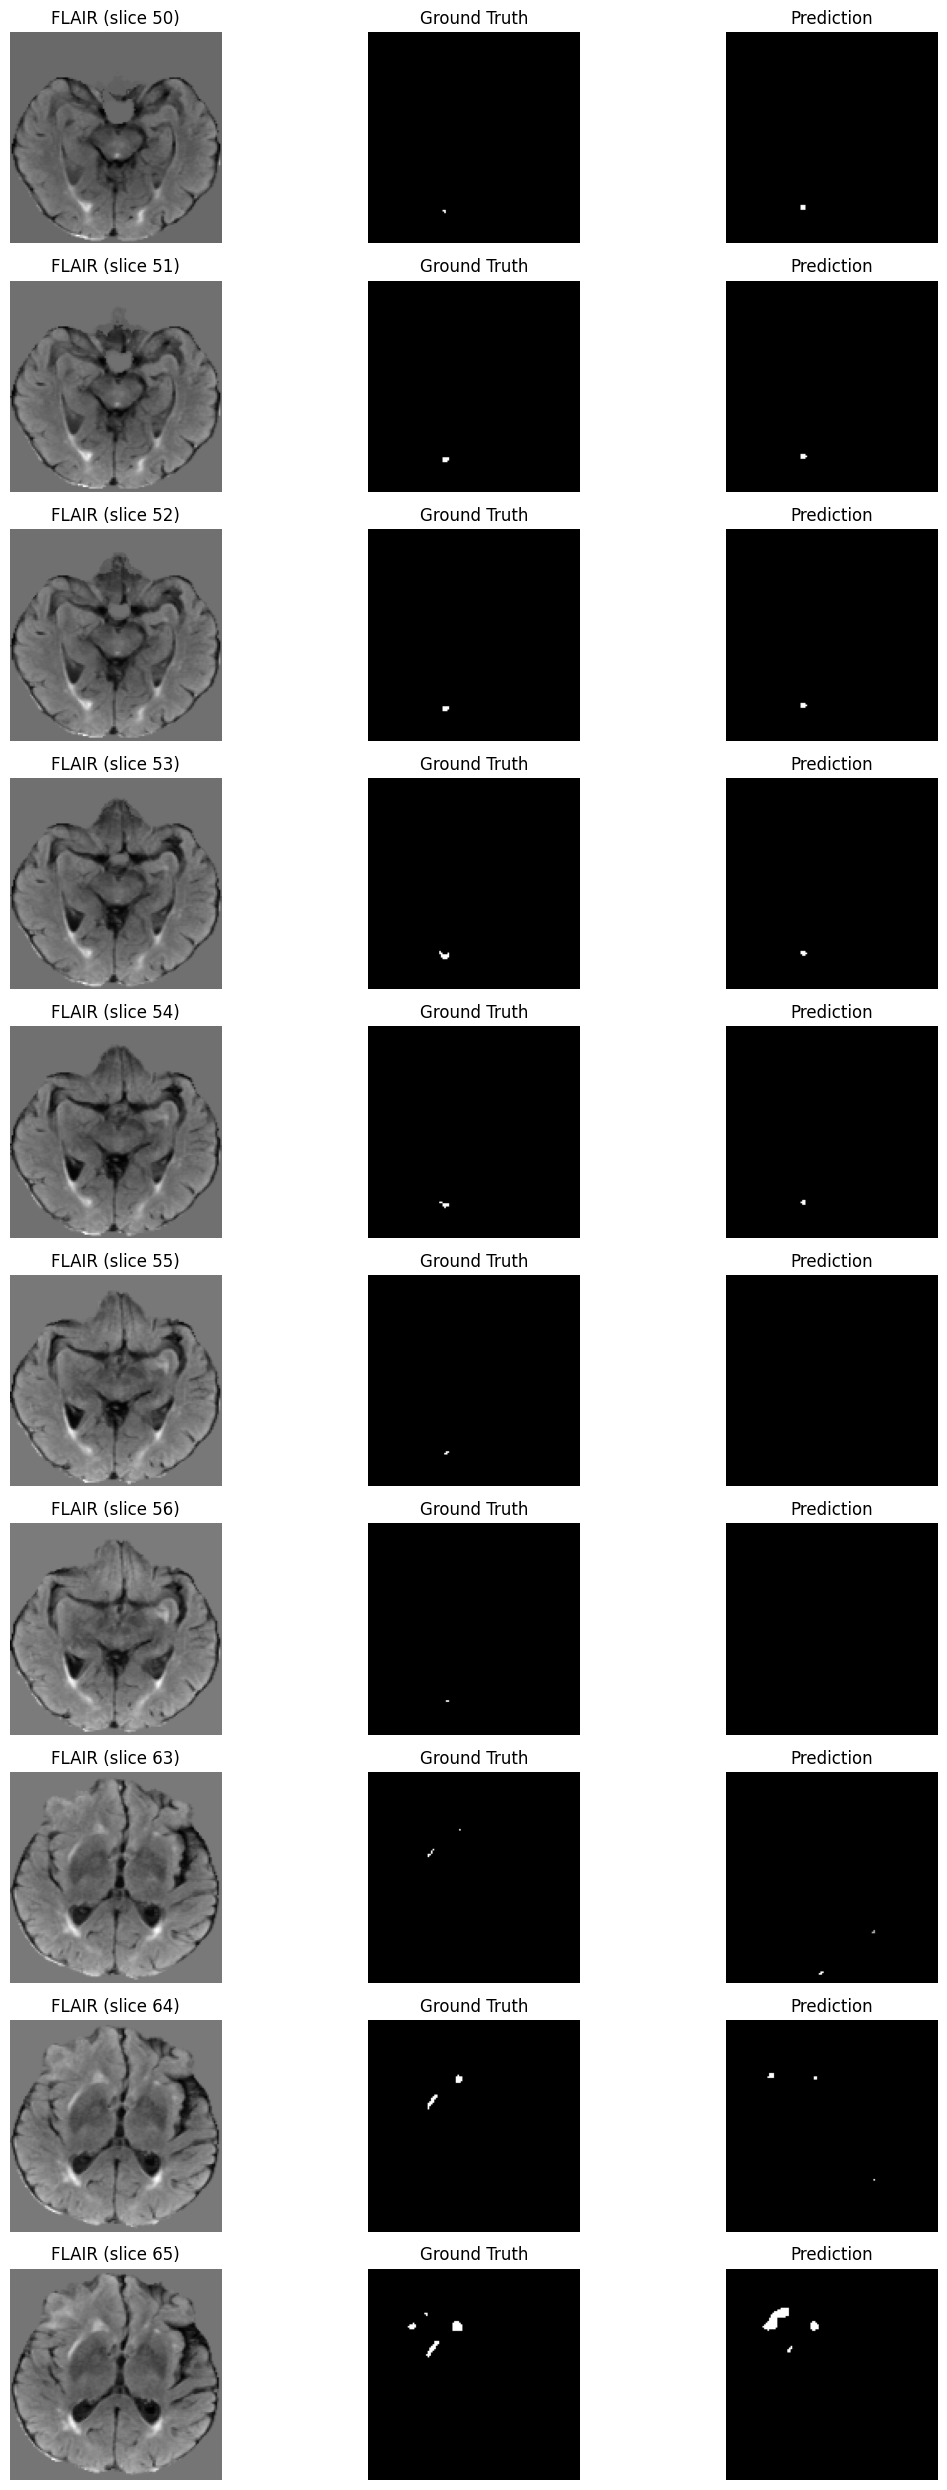

In [54]:
def comparison_grid(X, Y, pred_mask, save=True):
    tumor_slices = np.where(Y.sum(axis=(1,2)) > 0)[0][:10]

    plt.figure(figsize=(12, 25))

    for i, s in enumerate(tumor_slices):
        # FLAIR
        plt.subplot(10, 3, 3*i + 1)
        plt.imshow(X[0,s], cmap="gray")
        plt.title(f"FLAIR (slice {s})")
        plt.axis("off")

        # GT
        plt.subplot(10, 3, 3*i + 2)
        plt.imshow(Y[s], cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(10, 3, 3*i + 3)
        plt.imshow(pred_mask[s], cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    if save:
        plt.savefig("samples/comparison_grid.png", dpi=300)
    plt.show()

comparison_grid(X, Y, pred_mask)


In [56]:
import matplotlib.pyplot as plt
import numpy as np

def save_individual_tumor_slices(X, Y, pred_mask, save_dir="samples"):
    os.makedirs(save_dir, exist_ok=True)

    tumor_slices = np.where(Y.sum(axis=(1,2)) > 0)[0]
    if len(tumor_slices) == 0:
        print("⚠️ No tumor slices found.")
        return

    print(f"Saving {len(tumor_slices)} slices...")

    for idx, s in enumerate(tumor_slices):
        plt.figure(figsize=(12, 4))

        # 1. FLAIR
        plt.subplot(1, 3, 1)
        plt.imshow(X[0, s], cmap="gray")
        plt.title(f"FLAIR (slice {s})")
        plt.axis("off")

        # 2. Ground Truth
        plt.subplot(1, 3, 2)
        plt.imshow(Y[s], cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # 3. Prediction
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[s], cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

        # Save image
        out_path = os.path.join(save_dir, f"slice_{s}.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()

    print(f"All slides saved to: {save_dir}")


In [57]:
save_individual_tumor_slices(X, Y, pred_mask, save_dir="samples")


Saving 71 slices...
All slides saved to: samples
